In [67]:
# rnn has weakness for long sequences. That’s what LSTMs tries to solve.
# enables important information to be kept for a long time:
# it does not forget information just because of time (note that he can actively forget tho).
import numpy as np 
import pandas as pd
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [68]:
data = pd.read_csv('../input/cat-pp/concated.csv')

In [69]:
data.head()

,name,type
0,"krups f15b0g 12-cup glass carafe, white",houseware
1,jason taylor for invicta collection 13687 blac...,watches
2,nintendo three piece zipper pull / keychain se...,accessories
3,plain fitted hat - khaki,accessories
4,nike shox nz womens running shoes 580574-456,shoes


In [70]:

data.type.value_counts()

tools          9000
beauty         9000
houseware      9000
watches        9000
clothing       9000
shoes          9000
accessories    8120
Name: type, dtype: int64

In [71]:
#I do aspire here to have balanced classes
concated = data
concated['LABEL'] = 0

In [72]:
#One-hot encode the lab
concated.loc[concated['type'] == 'clothing', 'LABEL'] = 0
concated.loc[concated['type'] == 'tools', 'LABEL'] = 1
concated.loc[concated['type'] == 'accessories', 'LABEL'] = 2
concated.loc[concated['type'] == 'shoes', 'LABEL'] = 3
concated.loc[concated['type'] == 'watches', 'LABEL'] = 4
concated.loc[concated['type'] == 'houseware', 'LABEL'] = 5
concated.loc[concated['type'] == 'beauty', 'LABEL'] = 6

print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=7)
print(labels[:10])
if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1)

0    5
1    4
2    2
3    2
4    3
5    6
6    4
7    4
8    6
9    5
Name: LABEL, dtype: int64
[[0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]]


In [73]:
n_most_common_words = 8000
max_len = 100
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(names['Product Name'].values)
sequences = tokenizer.texts_to_sequences(concated['name'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 12404 unique tokens.


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [75]:
epochs = 10
emb_dim = 128
batch_size = 256

In [76]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size,validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=7, 
                                             min_delta=0.0001)])

# patience argument represents the number of epochs before stopping once your loss starts to increase (stops improving). 

((46590, 100), (46590, 7), (15530, 100), (15530, 7))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 100, 128)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 455       
Total params: 1,073,863
Trainable params: 1,073,863
Non-trainable params: 0
_________________________________________________________________
None
Train on 37272 samples, validate on 9318 samples
Epoch 1/10
37272/37272 [==============================] - 29s 779us/step - loss: 1.6966 - acc: 0.3942 - val_loss: 1.1334 - val_acc: 0.6829
Epoch 2/10
37272/3

In [77]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

15530/15530 [==============================] - 30s 2ms/step
Test set
  Loss: 0.508
  Accuracy: 0.832


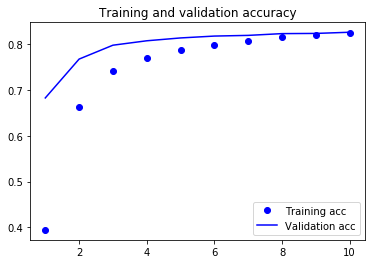

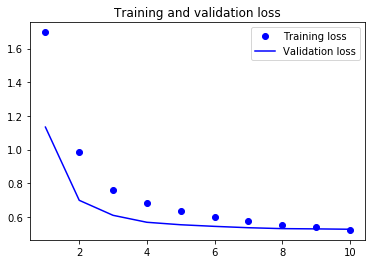

In [78]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [79]:
names = pd.read_csv('../input/test-set/ecommerce_product_names.csv')

In [80]:
n_most_common_words = 8000
max_len = 100
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(names['Product Name'].values)
sequences = tokenizer.texts_to_sequences(names['Product Name'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_names = pad_sequences(sequences, maxlen=max_len)

Found 12404 unique tokens.


In [81]:
yhat = model.predict_classes(X_names, verbose=0)
print(yhat)

[0 5 2 ... 3 3 1]


In [82]:
label_list = ['clothing', 'tools', 'accessories', 'shoes', 'watches', 'houseware', 'beauty']
results = [label_list[i] for i in yhat]

In [83]:
names['prediction'] = results

In [84]:
names

,Product Name,prediction
0,Alisha Solid Women's Cycling Shorts,clothing
1,FabHomeDecor Fabric Double Sofa Bed,houseware
2,AW Bellies,accessories
3,Sicons All Purpose Arnica Dog Shampoo,beauty
4,Eternal Gandhi Super Series Crystal Paper Weig...,tools
5,"dilli bazaaar Bellies, Corporate Casuals, Casuals",shoes
6,Ladela Bellies,accessories
7,Carrel Printed Women's,clothing
8,Sicons All Purpose Tea Tree Dog Shampoo,beauty
9,Freelance Vacuum Bottles 350 ml Bottle,houseware


In [ ]:
# future work, try bi directional lstm